In [1]:
import pandas as pd
import numpy as np

In [2]:
def status(feature):
    print('Processing', feature, ': ok')

In [3]:
def get_alldata_data():
    # reading train data
    train = pd.read_csv('data/train.csv')
    
    # reading test data
    test = pd.read_csv('data/test.csv')

    # extracting and then removing the targets from the training data 
    targets = train.Survived
    train.drop(['Survived'], 1, inplace=True)
    

    # merging train data and test data for future feature engineering
    # we'll also remove the PassengerID since this is not an informative feature
    alldata = train.append(test)
    alldata.reset_index(inplace=True)
    alldata.drop(['index', 'PassengerId'], inplace=True, axis=1)
    
    return alldata

In [4]:
alldata = get_alldata_data()

In [5]:
alldata.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
print(alldata.shape)

(1309, 10)


### Delete Name and Ticket

In [7]:
alldata = alldata.drop(['Name','Ticket'], axis=1)

In [8]:
alldata.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,NaN,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,NaN,S


### Sex

In [9]:
def process_sex():
    global alldata
    # dummy encoding 
    sex_dummies = pd.get_dummies(alldata['Sex'], prefix='Sex')
    alldata = pd.concat([alldata, sex_dummies], axis=1)
    alldata.drop('Sex', axis=1, inplace=True)
    status('sex')
    return alldata

In [10]:
alldata = process_sex()

Processing sex : ok


In [11]:
alldata.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Sex_female,Sex_male
0,3,22.0,1,0,7.2500,NaN,S,0,1
1,1,38.0,1,0,71.2833,C85,C,1,0
2,3,26.0,0,0,7.9250,NaN,S,1,0
3,1,35.0,1,0,53.1000,C123,S,1,0
4,3,35.0,0,0,8.0500,NaN,S,0,1


### Age

Number of missing ages in train set

In [12]:
print(alldata.iloc[:891].Age.isnull().sum())

177


Number of missing ages in test set

In [13]:
print(alldata.iloc[891:].Age.isnull().sum())

86


In [14]:
grouped_train = alldata.iloc[:891].groupby(['Pclass'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Pclass', 'Age']]

In [15]:
grouped_median_train.head()

,Pclass,Age
0,1,37.0
1,2,29.0
2,3,24.0


In [16]:
def fill_age(row):
    condition = ((grouped_median_train['Pclass'] == row['Pclass'])) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global alldata
    # a function that fills the missing values of the Age variable
    alldata['Age'] = alldata.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    status('age')
    return alldata

In [17]:
alldata = process_age()

Processing age : ok


In [18]:
alldata.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Sex_female,Sex_male
0,3,22.0,1,0,7.2500,NaN,S,0,1
1,1,38.0,1,0,71.2833,C85,C,1,0
2,3,26.0,0,0,7.9250,NaN,S,1,0
3,1,35.0,1,0,53.1000,C123,S,1,0
4,3,35.0,0,0,8.0500,NaN,S,0,1


### Fare

In [22]:
def process_fares():
    global alldata
    # there's one missing fare value - replacing it with the mean.
    alldata.Fare.fillna(alldata.iloc[:891].Fare.mean(), inplace=True)
    status('fare')
    return alldata

In [23]:
alldata = process_fares()

Processing fare : ok


In [24]:
alldata.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Sex_female,Sex_male
0,3,22.0,1,0,7.2500,NaN,S,0,1
1,1,38.0,1,0,71.2833,C85,C,1,0
2,3,26.0,0,0,7.9250,NaN,S,1,0
3,1,35.0,1,0,53.1000,C123,S,1,0
4,3,35.0,0,0,8.0500,NaN,S,0,1


### Cabin

In [25]:
train_cabin, test_cabin = set(), set()

for c in alldata.iloc[:891]['Cabin']:
    try:
        train_cabin.add(c[0])
    except:
        train_cabin.add('U')
        
for c in alldata.iloc[891:]['Cabin']:
    try:
        test_cabin.add(c[0])
    except:
        test_cabin.add('U')

In [26]:
print(train_cabin)

{'E', 'G', 'A', 'B', 'C', 'T', 'F', 'D', 'U'}


In [27]:
print(test_cabin)

{'E', 'G', 'A', 'C', 'F', 'D', 'U', 'B'}


In [28]:
def process_cabin():
    global alldata    
    # replacing missing cabins with U (for Uknown)
    alldata.Cabin.fillna('U', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    alldata['Cabin'] = alldata['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(alldata['Cabin'], prefix='Cabin')    
    alldata = pd.concat([alldata, cabin_dummies], axis=1)

    alldata.drop('Cabin', axis=1, inplace=True)
    status('cabin')
    return alldata

In [29]:
alldata = process_cabin()

Processing cabin : ok


In [30]:
alldata.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,22.0,1,0,7.2500,S,0,1,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,C,1,0,0,0,1,0,0,0,0,0,0
2,3,26.0,0,0,7.9250,S,1,0,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,S,1,0,0,0,1,0,0,0,0,0,0
4,3,35.0,0,0,8.0500,S,0,1,0,0,0,0,0,0,0,0,1


### Embarked

In [31]:
def process_embarked():
    global alldata
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    alldata.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    embarked_dummies = pd.get_dummies(alldata['Embarked'], prefix='Embarked')
    alldata = pd.concat([alldata, embarked_dummies], axis=1)
    alldata.drop('Embarked', axis=1, inplace=True)
    status('embarked')
    return alldata

In [32]:
alldata = process_embarked()

Processing embarked : ok


In [33]:
alldata.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,0,0,0,0,0,0,1,0,0,1


# Modelling

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [36]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [39]:
def recover_train_test_target():
    global alldata
    
    targets = pd.read_csv('data/train.csv', usecols=['Survived'])['Survived'].values
    train = alldata.iloc[:891]
    test = alldata.iloc[891:]
    
    return train, test, targets

In [40]:
train, test, targets = recover_train_test_target()

### Feature selection

In [41]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

In [42]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

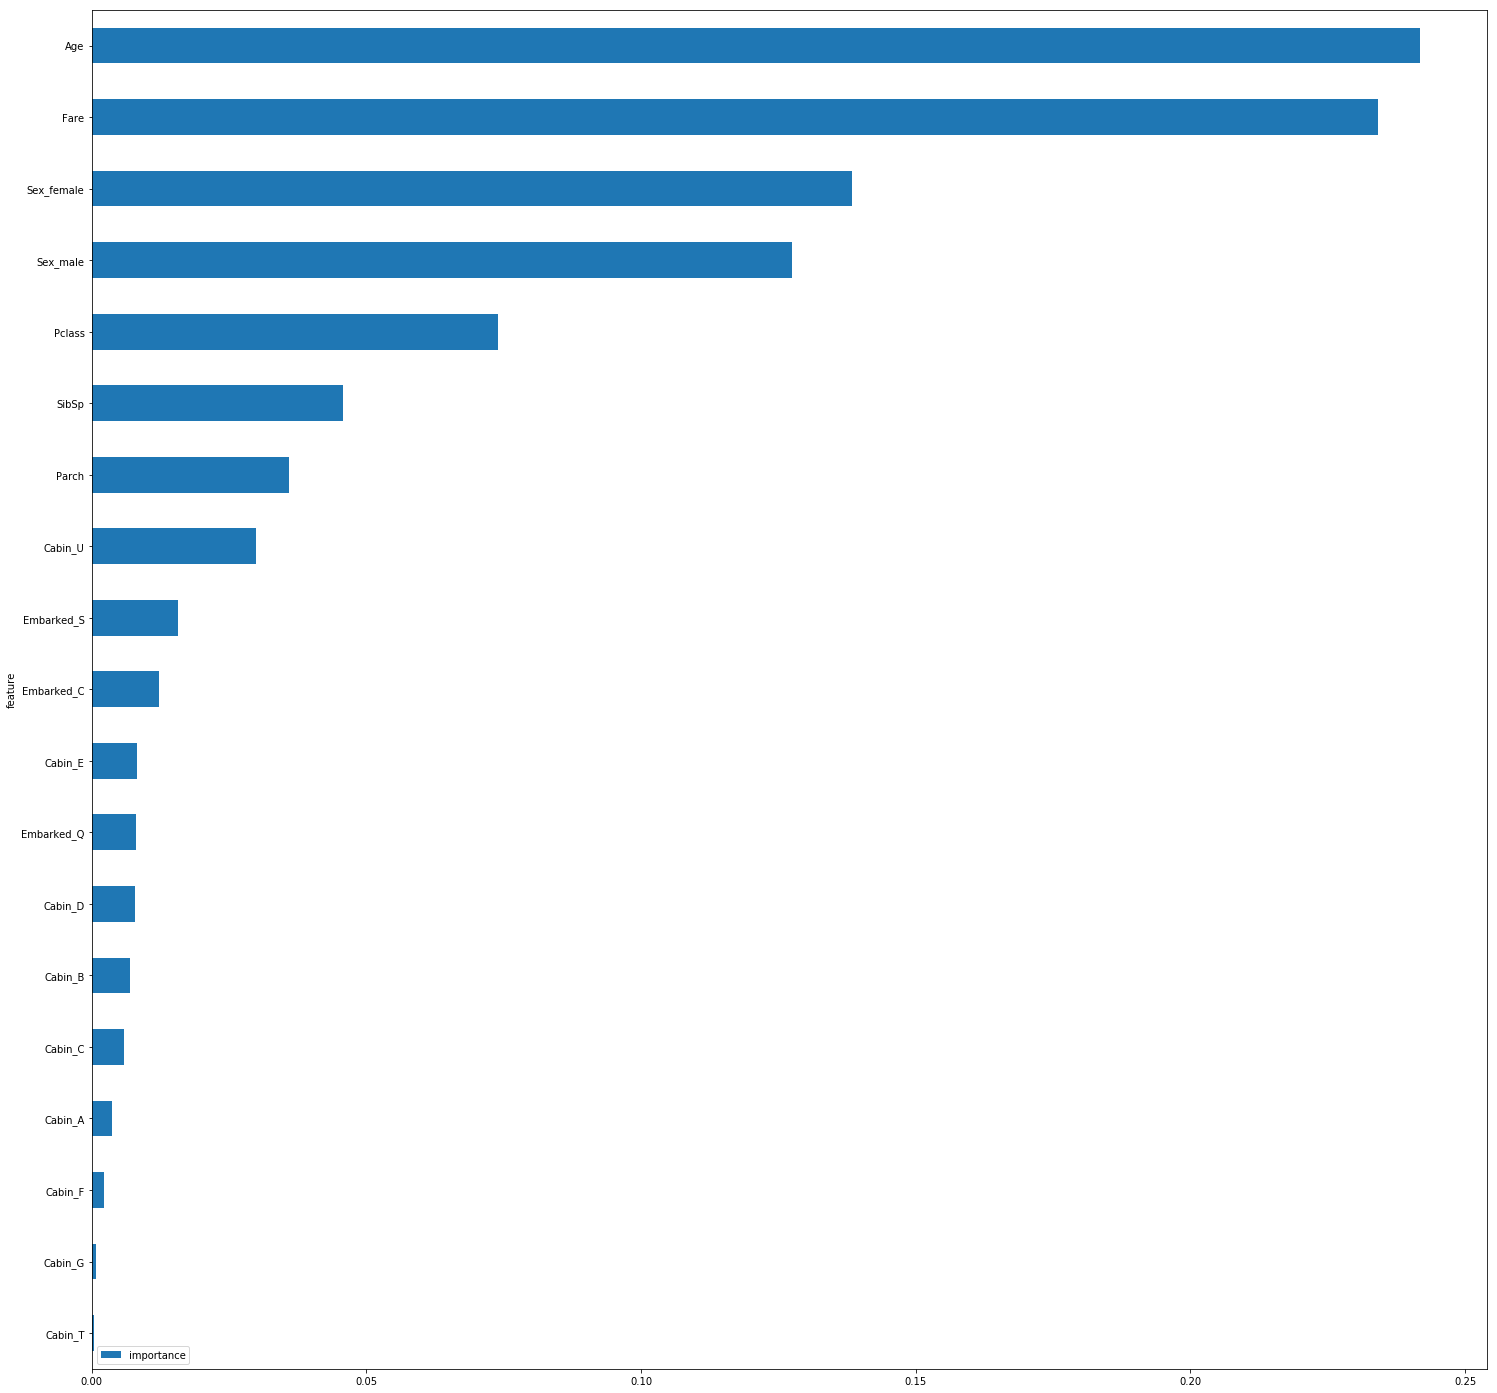

In [44]:
features.plot(kind='barh', figsize=(25, 25))

In [46]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print(train_reduced.shape)

(891, 5)


In [47]:
test_reduced = model.transform(test)
print(test_reduced.shape)

(418, 5)


In [48]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

In [49]:
for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print('CV score = {0}'.format(score))
    print('****')

Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score = 0.7878575225717404
****
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
CV score = 0.7834260531025924
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.8137004319829831
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.8193186222931024
****


### Hyperparameters tuning

In [50]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

In [55]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('predictions/mygridsearch_rf.csv', index=False)

### Blending different models

In [56]:
trained_models = []
for model in models:
    model.fit(train, targets)
    trained_models.append(model)

predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(test)[:, 1])

predictions_df = pd.DataFrame(predictions).T
predictions_df['out'] = predictions_df.mean(axis=1)
predictions_df['PassengerId'] = aux['PassengerId']
predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)

predictions_df = predictions_df[['PassengerId', 'out']]
predictions_df.columns = ['PassengerId', 'Survived']

In [57]:
predictions_df.to_csv('predictions/myblending_base_models.csv', index=False)